<a href="https://colab.research.google.com/github/tagtog12000/GrandPotentialPython/blob/main/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔽 Cloning repository: https://github.com/tagtog12000/GrandPotentialPython.git
⚠️ No requirements.txt found — skipping dependency install.
fatal: destination path 'GrandPotentialPython' already exists and is not an empty directory.
/content/GrandPotentialPython
Usage: ./main_exec nMax eps
Enter the maximum order nMax: 5
Enter the particle statistics, eps (-1 for fermions and 1 for bosons): -1
✅ Program output:



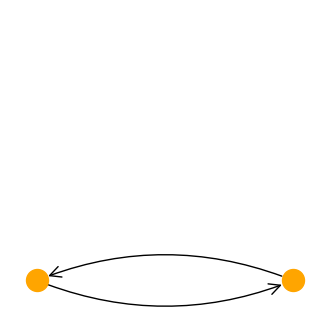

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

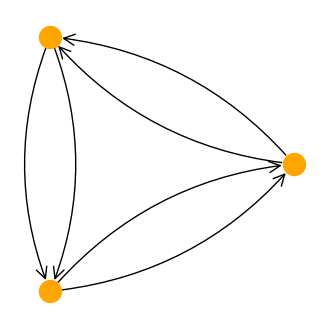

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

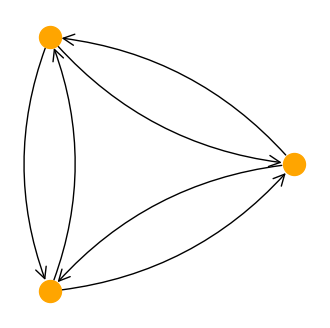

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

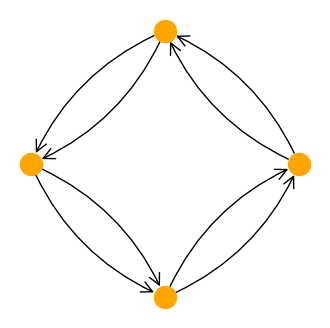

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

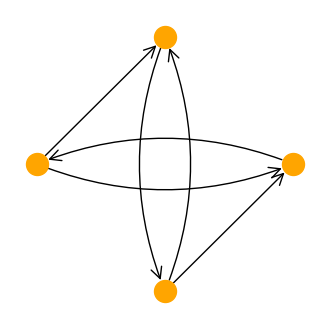

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

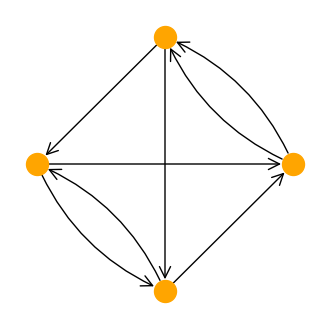

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

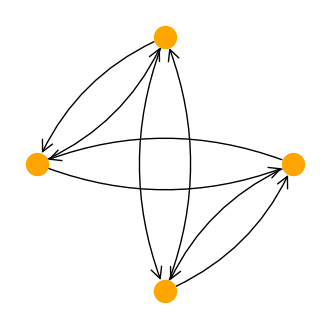

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

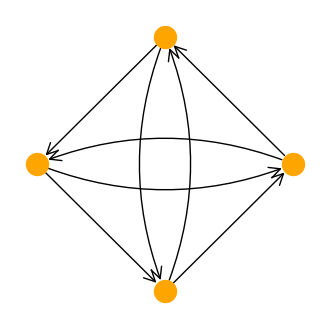

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

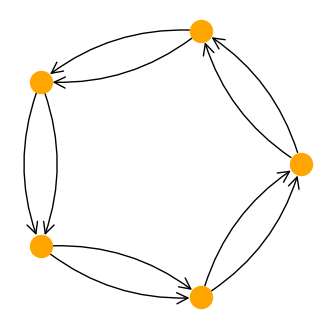

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

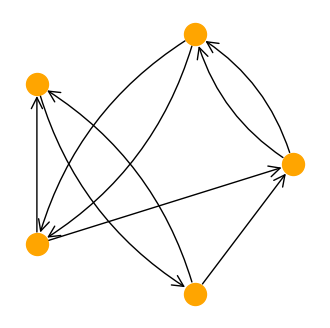

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

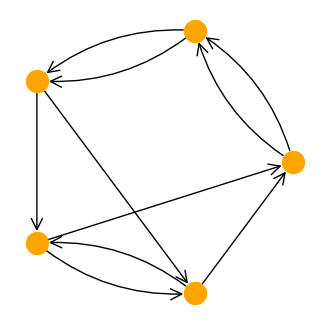

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

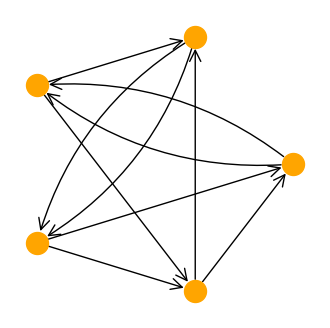

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

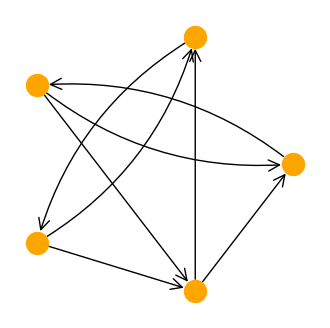

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

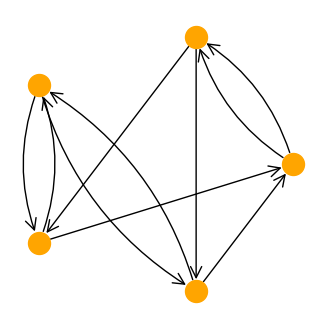

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

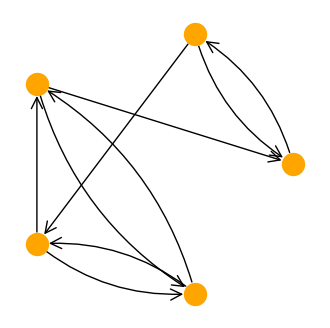

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

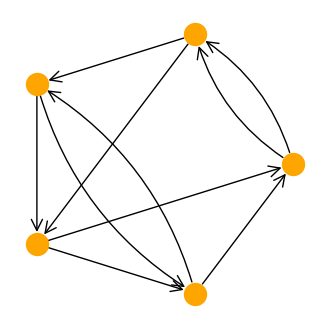

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

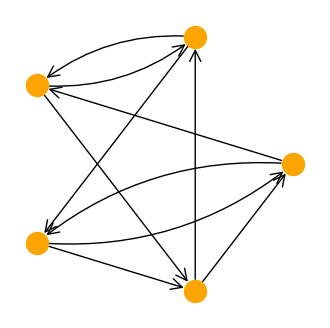

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

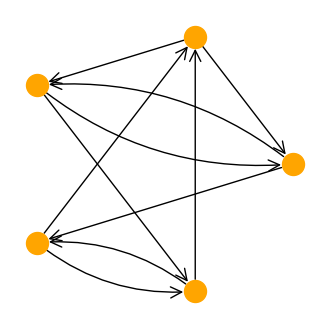

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

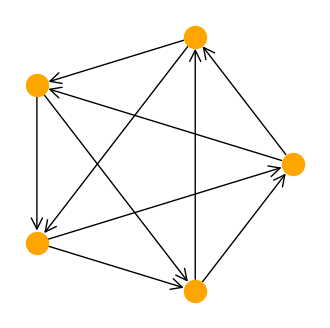

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

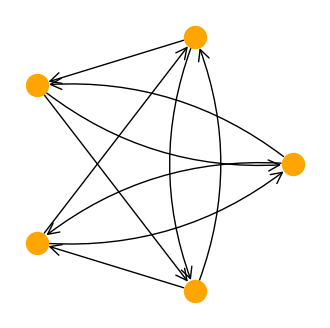

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

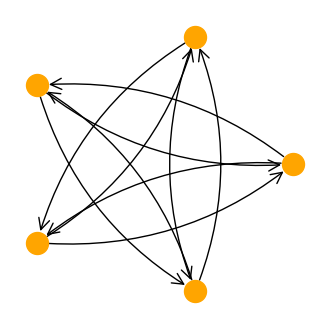

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [1]:
from google.colab import files
from IPython.display import display, Latex, HTML
import ast
import matplotlib.pyplot as plt
import networkx as nx
import math
from collections import Counter
import numpy as np
import loadCode

def draw_multidigraph(G_edges, radius=2.0, figsize=(4,4), node_color="orange"):
    # Build graph
    G = nx.MultiDiGraph()
    G.add_edges_from(G_edges)

    # Nodes
    nodes = sorted(set([u for u,v in G_edges] + [v for u,v in G_edges]))
    n = len(nodes)

    # Arrange nodes on a circle
    pos = {}
    for i, node in enumerate(nodes, start=1):
        angle = 2 * math.pi * (i-1) / n
        pos[node] = (radius * math.cos(angle), radius * math.sin(angle))

    # Count multiplicities
    edge_count = Counter(G_edges)

    # Track drawn edges
    drawn = set()

    plt.figure(figsize=figsize)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=250, node_color=node_color, edgecolors=node_color)

    # Draw edges with logic
    for (u, v), count in edge_count.items():
        if (u, v) in drawn:
            continue

        opp = (v, u)
        if opp in edge_count:
            # Opposite directed edges → bend left/right
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                   arrowstyle="->", arrowsize=20,
                                   connectionstyle="arc3,rad=0.2")
            nx.draw_networkx_edges(G, pos, edgelist=[(v, u)],
                                   arrowstyle="->", arrowsize=20,
                                   connectionstyle="arc3,rad=0.2")
            drawn.add((u, v))
            drawn.add((v, u))
        elif count == 1:
            # Single edge → straight
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                   arrowstyle="->", arrowsize=20)
            drawn.add((u, v))
        elif count == 2:
            # Two parallel edges same direction → bend left/right
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                   arrowstyle="->", arrowsize=20,
                                   connectionstyle="arc3,rad=0.2")
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                   arrowstyle="->", arrowsize=20,
                                   connectionstyle="arc3,rad=-0.2")
            drawn.add((u, v))
        else:
            # More than 2 parallels → spread bends
            k = count
            rads = [0] if k % 2 == 1 else []
            for i in range(1, (k//2)+1):
                rads.extend([0.2*i, -0.2*i])
            for r in rads[:k]:
                if r == 0:
                    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                           arrowstyle="->", arrowsize=20)
                else:
                    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                           arrowstyle="->", arrowsize=20,
                                           connectionstyle=f"arc3,rad={r}")
            drawn.add((u, v))

    plt.axis("off")
    plt.show()

def toInt(intU: int):
    lis = []
    pos = 1
    while intU:
        if intU & 1:
            lis.append(pos)
        intU >>= 1
        pos += 1
    return lis;

def bit_positions(n):
    return [f"p_{i+1}" for i in range(n.bit_length()) if (n >> i) & 1]

def writeUlli(intU: int, s1: str, sm: str, s2: str, s0, bol = 1):
    tex=""
    pos = 1
    pos0 = 1
    while intU:
        if intU & 1:
            if pos0 == 1:
                if bol == 0:
                    tex+=s1+sm+str(pos)+s2
                else:
                    tex+=s0+s1+str(pos)+s2
                pos0 += 1
            else:
                tex+=s0+s1+sm+str(pos)+s2
        intU >>= 1
        pos += 1
    return tex;

def remplaceVariable(refDens: list, var: str, spTr: int):
    remP = {}   # dictionary for remplacing variables
    for refDen in refDens:
        posD = refDen[0] ^ refDen[1]
        if posD & spTr:
            br = posD & spTr
            posSTr = br.bit_length()
            posD = posD ^ br
            tx1 = var + str(posSTr)
            tx2 = writeUlli(posD, "-", var, "") + writeUlli(refDen[1], "+", var, "")
            remP[tx1] = tx2
        elif refDen[1] & spTr:
            br = refDen[1] & spTr
            posSTr = br.bit_length()
            refDen[1] = refDen[1] ^ br
            tx1 = var + str(posSTr)
            tx2 = writeUlli(refDen[1], "-", var, "") + writeUlli(posD, "+", var, "")
            remP[tx1] = tx2
        else:
            print("error")
    return remP

def build_latex(matCoefF, matNumSignF, matDenNigF, graphs, symmetries, refSpanningTrees, refDens, ones, n):
    for i in range(len(graphs)):
        sym = symmetries[i]
        spTr = refSpanningTrees[i]
        edges = graphs[i]
        draw_multidigraph(edges)
        pot = ""
        for j in range(n):
            pot += "\\langle "+str(2*j+1) + "," + str(2*j+2) + " || "  + str(2*edges[2*j+1][1] - 1)+ ","  + str(2*edges[2*j+1][1]) + " \\rangle"
        if sym < 0:
            sym = -sym
            tsym = "-"
        else:
            tsym = ""
        tsym ="V_{"+str(n)+"}^{"+str(i+1)+"} = "+tsym+"\\frac{1}{"+str(sym)+"}"+pot
        #print(tsym)

        fraction_latex = "\\Omega_{"+str(n)+"}^{"+str(i+1)+"} = "
        matNS = matNumSignF[i]
        cfi = matCoefF[i]
        for ij in range(len(matNS)):
            tex = ""
            txtN = ""
            for j in range(len(matNS[ij])):
                coef = cfi[ij][j]
                if coef == -1:
                    txtN+="-"
                elif coef == 1:
                    if j == 0:
                        txtN+=""
                    else:
                        txtN+="+"
                elif coef < -1:
                    tex+=str(coef)
                else:  # coef > 1
                    txtN+="+"+str(coef)
                # n^- terms
                txtN+=writeUlli(matNS[ij][j][1], "f_{", "", "}", "",0)

                # n^+ terms
                txtN+=writeUlli(matNS[ij][j][0] ^ matNS[ij][j][1], "g_{", "", "}", "",0)

            # denominator
            txtD = ""
            for j in range(len(matDenNigF[i][ij])):
                txtD+="("
                # -E terms
                txtD+=writeUlli(matDenNigF[i][ij][j][1], "-", "E_{", "", "}",0)
                # +E terms
                txtD+=writeUlli(matDenNigF[i][ij][j][0] ^ matDenNigF[i][ij][j][1], "+", "E_{", "", "}",0)
                txtD+=")"
            tex0 = "\\frac{"+txtN +"}{"+ txtD +"}"  # reset for each fraction numerator
            if ij == 0:
                tex += tex0
            else:
                tex += "+"+tex0

            # join into string
            fraction_latex += tex
        display(Latex(tsym))
        display(Latex(fraction_latex))
        #display(fraction_latex)

#begin construction

allData = []  # list to hold data for all n
for n in range(2, nMax+1):
    data_n = {}  # dictionary to hold data for this specific n

    with open(f"matCoefF-{n}.dat") as f:
        data_n["matCoefF"] = ast.literal_eval(f.read())

    with open(f"matDenNigF-{n}.dat") as f:
        data_n["matDenNigF"] = ast.literal_eval(f.read())

    with open(f"matNumSignF-{n}.dat") as f:
        data_n["matNumSignF"] = ast.literal_eval(f.read())

    with open(f"graphs-{n}.dat") as f:
        data_n["graphs"] = ast.literal_eval(f.read())

    with open(f"spanningTrees-{n}.dat") as f:
        data_n["spanningTrees"] = ast.literal_eval(f.read())

    with open(f"symmetries-{n}.dat") as f:
        data_n["symmetries"] = ast.literal_eval(f.read())

    with open(f"refDenominators-{n}.dat") as f:
        data_n["refDenominators"] = ast.literal_eval(f.read())

    with open("DivDifMB-"+str(n)+".dat") as f:
         data_n["DivDifMB"] = ast.literal_eval(f.read())

    dn = 2*n
    ones = (1 << (dn))-1

    build_latex(data_n["matCoefF"], data_n["matNumSignF"], data_n["matDenNigF"], data_n["graphs"], data_n["symmetries"], data_n["spanningTrees"], data_n["refDenominators"], ones, n)